In [3]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=[]


# Pilot whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC


In [1]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [2]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter
from avgn_paper.signalprocessing import spectrogramming as sg
import wave

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [3]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC/')

In [4]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC')

### load wavs

In [5]:
wavs = list(DSLOC.glob('*.wav'))
len(wavs), wavs[:3]

(6,
 [PosixPath('/mnt/cube/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC/Set1-A2-092405-H18-0605-0635-1613-1643loc.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC/Set1-A2-092405-H19-0605-0635-1613-1643loc.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC/Set3-A2-092605-H23-0615-0630-1450-1505loc.wav')])

In [6]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate'])
for wav in wavs:
    with wave.open(wav.as_posix(), 'rb') as f:
        rate = f.getframerate()
    wav_df.loc[len(wav_df)] = [wav.stem, wav, rate]

In [7]:
wav_df

,stem,path,rate
0,Set1-A2-092405-H18-0605-0635-1613-1643loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000
1,Set1-A2-092405-H19-0605-0635-1613-1643loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000
2,Set3-A2-092605-H23-0615-0630-1450-1505loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000
3,Set7-A1-093005-H01-0030-0100-0846-0916loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000
4,Set1-A2-092405-H16-0605-0635-1613-1643loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000
5,Set1-A2-092405-H20-0605-0635-1613-1643loc,/mnt/cube/Datasets/mobysound/Pilot_whales_Baha...,96000


### Load labels

In [10]:
click_types = [
    ['good', '*good.txt'],
    ['maybe1', '*maybe1.txt']
]

In [11]:
clicks_df = []
for click_type, click_type_glob in click_types:
    good_clicks = list(DSLOC.glob(click_type_glob))
    for click_label_loc in good_clicks:
        good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
        good_clicks_df['stem'] = click_label_loc.stem
        good_clicks_df['click_value'] = click_type
        clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

In [12]:
len(clicks_df)

15892

In [13]:
clicks_df[:3]

,% start time,end time,low freq,high freq,Unnamed: 4,stem,click_value
0,51.874,51.882,6294.029,45928.382,NaN,Set3-A2-092605-H23-0615-0630-1450-1505loc_good,good
1,54.831,54.837,7779.340,45928.382,NaN,Set3-A2-092605-H23-0615-0630-1450-1505loc_good,good
2,56.453,56.460,7388.468,45302.988,NaN,Set3-A2-092605-H23-0615-0630-1450-1505loc_good,good


In [14]:
clicks_df.columns

Index(['% start time', ' end time', ' low freq', ' high freq', 'Unnamed: 4',
       'stem', 'click_value'],
      dtype='object')

In [15]:
clicks_df.click_value.unique()

array(['good', 'maybe1'], dtype=object)

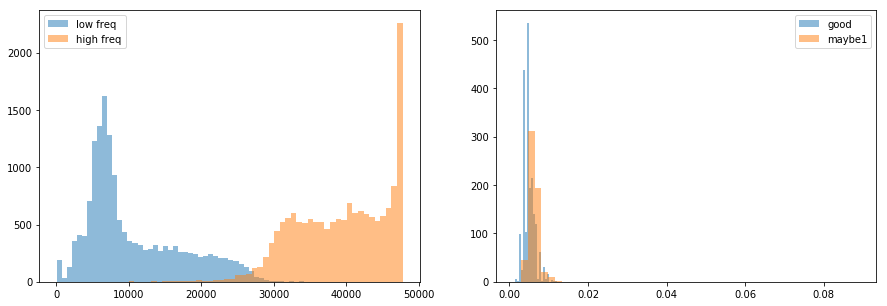

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(clicks_df[" low freq"].values, bins=50, alpha=0.5, label="low freq")
axs[0].hist(clicks_df[" high freq"].values, bins=50, alpha=0.5, label="high freq")

for click_value in clicks_df.click_value.unique():
    axs[1].hist(
        clicks_df[clicks_df.click_value == click_value][" end time"].values
        - clicks_df[clicks_df.click_value == click_value]["% start time"].values,
        bins=50, normed = True, label=click_value, alpha = 0.5
    )

axs[0].legend()
axs[1].legend()

### get example click

In [18]:
click_row = clicks_df.iloc[1]

In [19]:
click_row

% start time                                            54.831
 end time                                               54.837
 low freq                                              7779.34
 high freq                                             45928.4
Unnamed: 4                                                 NaN
stem            Set3-A2-092605-H23-0615-0630-1450-1505loc_good
click_value                                               good
Name: 1, dtype: object

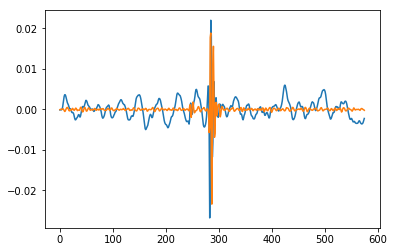

In [21]:
wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('_')[:-1])].iloc[0]
wav_loc = wav_row.path

rate = wav_row.rate
data, rate = librosa.core.load(
    path=wav_loc,
    sr=None,
    offset=click_row["% start time"],
    duration=click_row[" end time"] - click_row["% start time"],
    mono=False
)
data = np.transpose(data)
click = butter_bandpass_filter(data, lowcut = 100, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)
click = butter_bandpass_filter(click, lowcut = 10000, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)

In [22]:
rate

96000

In [31]:
win_length_ms = .25
hop_length_ms = .02
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

24.0
1.9200000000000002


In [32]:
spectrogram = sg.spectrogram(click, hparams)

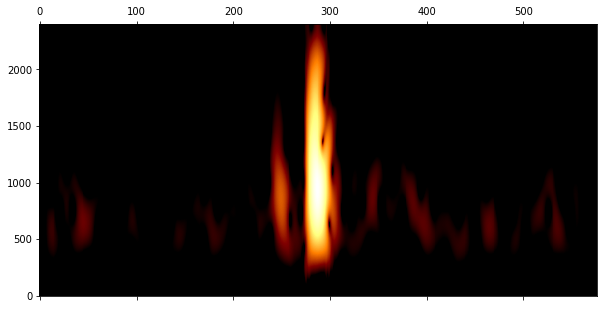

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [26]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

good


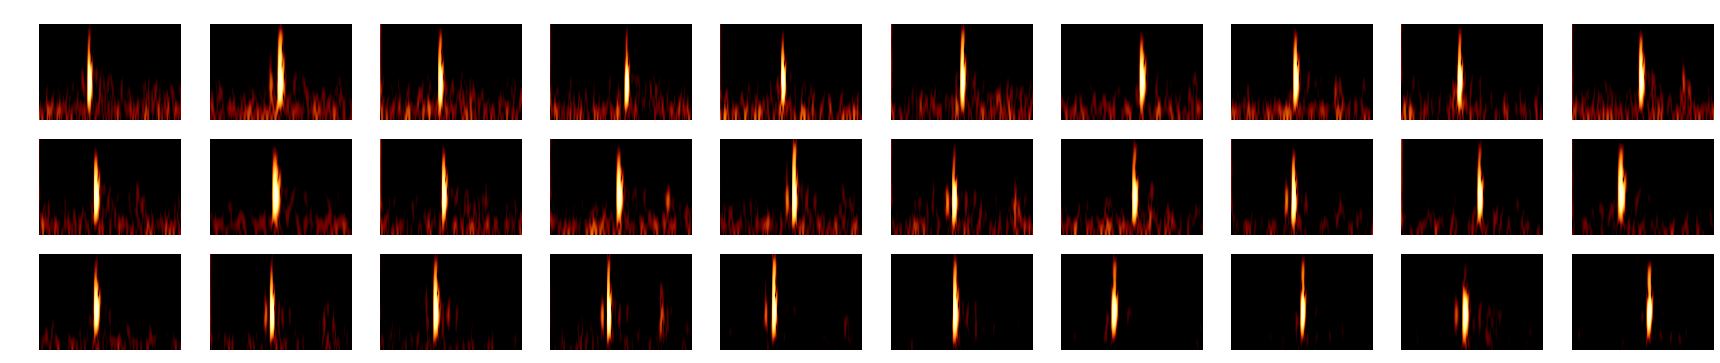

maybe1


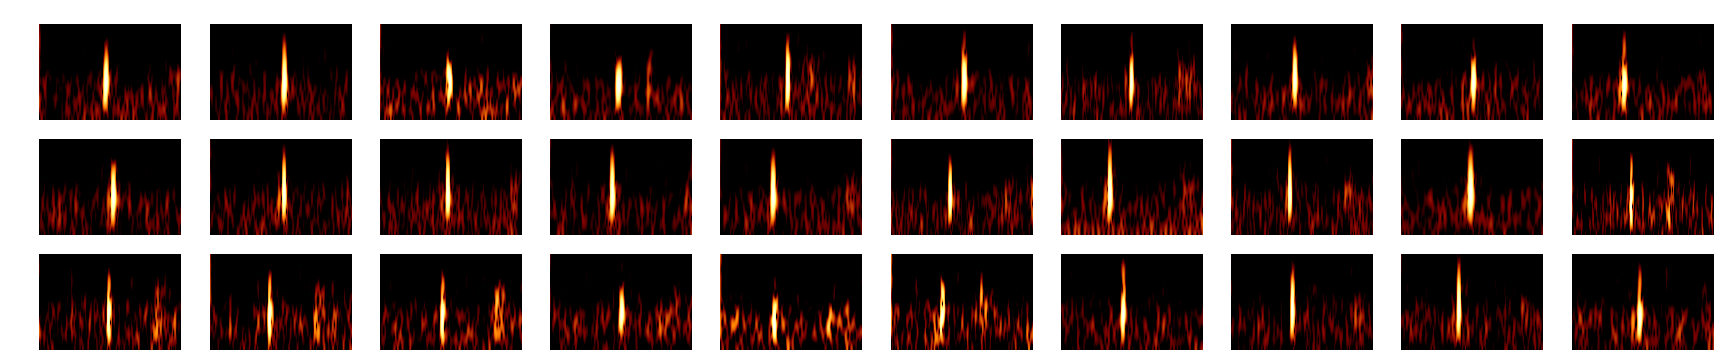

In [27]:
for click_value in clicks_df.click_value.unique():
    print(click_value)
    click_value_df = clicks_df[clicks_df.click_value == click_value]
    fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
    for axi in tqdm(range(nrow*ncol)):    

        click_row = click_value_df.iloc[axi]
        wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('_')[:-1])].iloc[0]
        wav_loc = wav_row.path

        rate = wav_row.rate
        data, rate = librosa.core.load(
            path=wav_loc,
            sr=None,
            offset=click_row["% start time"],
            duration=click_row[" end time"] - click_row["% start time"],
            mono=False
        )
        data = np.transpose(data)

        #audio = int16_to_float32(data)
        audio = butter_bandpass_filter(data, lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
        spectrogram = sg.spectrogram(audio, hparams)
        #mel_spec = np.dot(spectrogram.T, mel_matrix).T
        ax = axs.flatten()[axi] 
        ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        ax.axis('off')
    plt.show()